In [ ]:
import pandas as pd
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from google.colab import drive

from transformers import AdamW, XLMRobertaTokenizer, XLMRobertaForMaskedLM, XLMRobertaForSequenceClassification, XLMRobertaModel, BertForSequenceClassification, BertTokenizer, BertForMaskedLM, TFBertForSequenceClassification

from torch.utils.data import Dataset, DataLoader, TensorDataset
from keras.optimizers import Adam

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.regularizers import l2
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf


In [ ]:
# прикрутим драйв
drive.mount('/content/drive')

Mounted at /content/drive


## Начиная отсюда работаем по подготовке данных, используя обученный BERT

In [ ]:
# считаем и подготовим данные
import pandas as pd
# Try reading the CSV file while specifying the delimiter and handling bad lines
try:
    data = pd.read_csv('drive/MyDrive/MIPT/hackaton_result_dataset 2.csv', sep=';', on_bad_lines='skip')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

data.drop('Unnamed: 4', inplace=True, axis=1)
data.drop('audio_path', inplace=True, axis=1)

In [ ]:
# Тексты распознанные человеком
texts = list(data['human_markup'])

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512, mlm_probability=0.15):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mlm_probability = mlm_probability

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = inputs['input_ids'].clone()

        # Маскировка части токенов
        probability_matrix = torch.full(inputs['input_ids'].shape, self.mlm_probability)
        special_tokens_mask = self.tokenizer.get_special_tokens_mask(inputs['input_ids'], already_has_special_tokens=True)
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()
        inputs['input_ids'][masked_indices] = self.tokenizer.mask_token_id

        return inputs

# Настройка
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
dataset = TextDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=150, shuffle=True)

model = BertForMaskedLM.from_pretrained('DeepPavlov/rubert-base-cased')
model.train()

# Настройка оптимизатора
optimizer = AdamW(model.parameters(), lr=5e-5)

# Устройство для вычислений (GPU или CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Сохранение данных по loss
loss_mask_bert = []

# Функция для обновления графика
def update_plot(losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Steps')
    plt.legend()
    plt.show()

# Процесс дообучения
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0
    for step, batch in enumerate(dataloader):
        # Переносим данные на устройство
        inputs = {key: val.to(device) for key, val in batch.items()}

        # Получаем выходы модели
        outputs = model(**inputs)
        loss = outputs.loss

        # Обратное распространение ошибки и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Очистка кэша после каждого шага
        torch.cuda.empty_cache()

        step_loss = loss.item()
        epoch_loss += step_loss
        loss_mask_bert.append(step_loss)

        print(f"Epoch: {epoch + 1}, Step: {step + 1}, Loss: {step_loss}")

        update_plot(loss_mask_bert)

        print(f"Epoch: {epoch + 1}, Step: {step + 1}, Loss: {step_loss}")

    epoch_loss /= len(dataloader)
    print(f"Epoch: {epoch + 1}, Average Loss: {epoch_loss}")

# Сохранение дообученной модели
# model.save_pretrained('./fine_tuned_rubert2')
# tokenizer.save_pretrained('./fine_tuned_rubert2')

# Финальное построение графика изменения loss
update_plot(loss_mask_bert)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Здесь подготовка данных исходная, отделим тестовую выборку в самом начале, чтобы не было утечки

In [ ]:
# разделим данные на обучающую и тестовую выборки

from sklearn.model_selection import train_test_split

data = data.drop('human_markup', axis=1)

df_train, df_test = train_test_split(data, test_size=0.25, random_state=42)

In [ ]:
df_train.shape

(4880, 2)

## здесь дополнительно учим BERT но уже на задачу классификации (отсюда возьмем вероятности классов)

## начинаем составлять альтернативное представление признаков

In [ ]:
# Первое что сделаем: методом максирования представим условные вероятности каждого слова
from transformers import BertTokenizer, BertForMaskedLM
import torch
# Настройка токенизатора и модели
model_path = '/content/drive/MyDrive/MIPT/fine_tuned_xlm_roberta'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)
model = XLMRobertaForMaskedLM.from_pretrained(model_path)

# Функция для получения вероятностей слов
def get_word_probabilities(text):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    softmax_probs = torch.nn.functional.softmax(logits, dim=-1)
    word_probs = softmax_probs[0, range(len(inputs.input_ids[0])), inputs.input_ids[0]]
    return word_probs

# Пример использования функции
text = "пример текста на метамодернизм языке"
word_probs = get_word_probabilities(text)
for word, prob in zip(tokenizer.tokenize(text), word_probs):
    print(f"Word: {word}, Probability: {prob.item()}")

# работает странно, попробуем что-то еще)
учайно

Word: ▁пример, Probability: 0.999830961227417
Word: ▁текста, Probability: 0.9999997615814209
Word: ▁на, Probability: 0.9999983310699463
Word: ▁мета, Probability: 0.9999338388442993
Word: модерн, Probability: 0.9999933242797852
Word: изм, Probability: 1.0
Word: ▁языке, Probability: 0.9999964237213135


1) Маскируем случайное слово из данной фразы получаем предсказание и вероятность этого слова


И так далее пока не берем n-1 слов в последовательности N слов и вычисляем вероятность последнего слова

У нас получается вектор чисел вероятностей слов в данной фразе
И вектор чисел вероятностей во фразе где каждое следующее слово предложено моделью

Далее надо отнять первый эелмент из первого вектора (первое слово), вектора стали одинаковой длины, поэлементно перемножить и сложить произведения
Поэлементно вычесть второй вектор из первого и сложить результаты разницы

В результате получится кортеж из двух чисел

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
import numpy as np

# Загрузка дообученного токенизатора и модели
model_path = '/content/drive/MyDrive/MIPT/fine_tuned_xlm_roberta'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)
model = XLMRobertaForMaskedLM.from_pretrained(model_path)

# Функция для получения вероятностей и предсказанных вероятностей слов
def get_probabilities_and_predictions(text):
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs['input_ids']
    real_probabilities = []
    predicted_probabilities = []

    for i in range(1, input_ids.size(1) - 1):  # Пропускаем первый и последний токены (CLS и SEP)
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, i] = tokenizer.mask_token_id  # Маскируем текущее слово

        with torch.no_grad():
            outputs = model(masked_input_ids)

        logits = outputs.logits
        softmax_probs = torch.nn.functional.softmax(logits, dim=-1)

        real_word_prob = softmax_probs[0, i, input_ids[0, i]].item()  # Вероятность маскированного слова
        real_probabilities.append(real_word_prob)

        predicted_next_word_id = torch.argmax(logits[0, i]).item()  # Индекс наиболее вероятного следующего слова
        predicted_word_prob = softmax_probs[0, i, predicted_next_word_id].item()  # Вероятность наиболее вероятного следующего слова
        predicted_probabilities.append(predicted_word_prob)

    return real_probabilities, predicted_probabilities

# Функция для вычисления результата
def calculate_result(real_probs, predicted_probs):
    real_probs = real_probs[1:]  # Удаляем первый элемент
    combined_prob_product = sum([r * p for r, p in zip(real_probs, predicted_probs)])
    combined_prob_difference = sum([r - p for r, p in zip(real_probs, predicted_probs)])
    return combined_prob_product, combined_prob_difference

# Пример использования функций
text = "патисоны растут кванторами вверх"
real_probs, predicted_probs = get_probabilities_and_predictions(text)
result = calculate_result(real_probs, predicted_probs)
print(f"Result: {result}")


Result: (0.05805267528493803, -2.5087065128664108)


In [ ]:
# Отлично, у нас есть трейн и тест с дополненными фичами.
# Теперь добавим два признака вероятностей слов

# ооочень долго проходит инференс и дополнение датасета, 6 000 строк за полчаса на TPU

# Применение функций к обучающей выборке
train_features = df_train['model_annotation'].apply(lambda x: calculate_result(*get_probabilities_and_predictions(x)))
df_train['combined_prob_product'], df_train['combined_prob_difference'] = zip(*train_features)

# Применение функций к тестовой выборке
test_features = df_test['model_annotation'].apply(lambda x: calculate_result(*get_probabilities_and_predictions(x)))
df_test['combined_prob_product'], df_test['combined_prob_difference'] = zip(*test_features)


df_test.head()

In [ ]:
# сохраним промежуточный результат

df_test.to_csv('/content/drive/MyDrive/MIPT/data_test_propadd_2.csv', index=False)
df_train.to_csv('/content/drive/MyDrive/MIPT/data_train_data_propadd_2.csv', index=False)

In [ ]:
df_train_add

,model_annotation,label,combined_prob_product,combined_prob_difference
0,а что вы хотели то вас с кем то соединить или ...,0,0.514246,-2.583350
1,я ничего не перепутал это мне звонила женщина ...,0,0.629048,-0.940135
2,курочка кукарекает иначе,0,0.004913,-0.951606
3,сходила школьный двое поддал футбол там ребята...,1,0.116911,-2.979495
4,получение не удовольствие от самого процесса с...,1,0.096446,-1.020508
...,...,...,...,...
4875,тебе звонок из настал почему это,0,0.097803,-0.838602
4876,че хотели от нас,0,0.014082,-0.813639
4877,это весь запас словахный нет,0,0.000222,-0.429169
4878,это областной,1,0.036978,-0.114384


In [ ]:
df_test_add = pd.read_csv('/content/drive/MyDrive/MIPT/data_test_propadd_2.csv')
df_train_add = pd.read_csv('/content/drive/MyDrive/MIPT/data_train_data_propadd_2.csv')

## теперь добавим это признаковое описание к обучающей и тестовой выборке

In [ ]:
# сгененрируем эмбединги для каждой фразы длиной 128 (через PCA) и положим в модель (не сработало!!!)

df_test_add = pd.read_csv('/content/drive/MyDrive/MIPT/data_test_propadd_2.csv')
df_train_add = pd.read_csv('/content/drive/MyDrive/MIPT/data_train_data_propadd_2.csv')

# Загрузка дообученного токенизатора и модели
model_path = '/content/drive/MyDrive/MIPT/fine_tuned_xlm_roberta'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)
model = XLMRobertaModel.from_pretrained(model_path)
model.eval()

# Функция для получения эмбеддингов
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state  # Получаем последний скрытый слой
    embeddings = torch.mean(hidden_states, dim=1)  # Усредняем скрытые состояния по токенам
    return embeddings.squeeze().cpu().numpy()

# Применение функции к обучающей выборке
train_embeddings = df_train_add['model_annotation'].apply(get_embeddings)
train_embeddings = np.vstack(train_embeddings)  # Преобразуем список эмбеддингов в массив

# Применение функции к тестовой выборке
test_embeddings = df_test_add['model_annotation'].apply(get_embeddings)
test_embeddings = np.vstack(test_embeddings)  # Преобразуем список эмбеддингов в массив

# Применение PCA для уменьшения размерности до 16
pca = PCA(n_components=256)
train_embeddings_pca = pca.fit_transform(train_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)

print(train_embeddings_pca.shape)
print(test_embeddings_pca.shape)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/MIPT/fine_tuned_xlm_roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(4880, 256)
(1627, 256)


In [ ]:
# Добавление эмбеддингов в DataFrame как отдельные столбцы
df_train_embeddings = pd.DataFrame(train_embeddings_pca, columns=[f'e{i}' for i in range(256)])
df_train_add = pd.concat([df_train_add.reset_index(drop=True), df_train_embeddings.reset_index(drop=True)], axis=1)

df_test_embeddings = pd.DataFrame(test_embeddings_pca, columns=[f'e{i}' for i in range(256)])
df_test_add = pd.concat([df_test_add.reset_index(drop=True), df_test_embeddings.reset_index(drop=True)], axis=1)

print(df_train_add.shape)
print(df_test_add.shape)

(4880, 260)
(1627, 260)


In [ ]:
list(df_test.columns)

['model_annotation', 'label', 'predicted', 'prob']

In [ ]:
df_train_add_ready = df_train_add.drop(['model_annotation'], axis=1)
df_test_add_ready = df_test_add.drop(['model_annotation'], axis=1)

In [ ]:
print(df_train_add.shape)
print(df_test_add.shape)

(4880, 20)
(1627, 20)


In [ ]:
# здесь строим модели SVM и градиентный бустинг, добавляем результаты в датасет

X_train = df_train_add_ready.drop(columns=['label'])
y_train = df_train_add_ready['label'].values
X_test = df_test_add_ready.drop(columns=['label'])
y_test = df_test_add_ready['label'].values

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Генерация полиномиальных фич
poly = PolynomialFeatures(degree=7, include_bias=False)
train_poly_features = poly.fit_transform(df_train_add_ready[['combined_prob_product', 'combined_prob_difference']])
test_poly_features = poly.transform(df_test_add_ready[['combined_prob_product', 'combined_prob_difference']])

# Добавление полиномиальных фич в DataFrame
df_train_poly = pd.DataFrame(train_poly_features, columns=poly.get_feature_names_out(['combined_prob_product', 'combined_prob_difference']))
df_test_poly = pd.DataFrame(test_poly_features, columns=poly.get_feature_names_out(['combined_prob_product', 'combined_prob_difference']))

df_train_add_ready = pd.concat([df_train_add_ready.reset_index(drop=True), df_train_poly.reset_index(drop=True)], axis=1)
df_test_add_ready = pd.concat([df_test_add_ready.reset_index(drop=True), df_test_poly.reset_index(drop=True)], axis=1)

# Построение модели SVM и подбор гиперпараметров
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

pipeline_svm = Pipeline([
    ('svc', SVC(probability=True))
])

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Построение модели Gradient Boosting и подбор гиперпараметров
param_grid_gb = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.001, 0.01, 0.1],
    'gb__max_depth': [3, 4, 5, 10]
}

pipeline_gb = Pipeline([
    ('gb', GradientBoostingClassifier())
])

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Вывод оптимальных параметров и оценка моделей
best_model_svm = grid_search_svm.best_estimator_
y_pred_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]

roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

best_model_gb = grid_search_gb.best_estimator_
y_pred_proba_gb = best_model_gb.predict_proba(X_test)[:, 1]
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Best SVM parameters: {grid_search_svm.best_params_}")
print(f"SVM ROC-AUC: {roc_auc_svm}")
print(f"Best Gradient Boosting parameters: {grid_search_gb.best_params_}")
print(f"Gradient Boosting ROC-AUC: {roc_auc_gb}")

Best SVM parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
SVM ROC-AUC: 0.6648082208895552
Best Gradient Boosting parameters: {'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__n_estimators': 300}
Gradient Boosting ROC-AUC: 0.6582989755122439


In [ ]:
# Добавим предсказания SVM и градиентного бустинга в таблицу (НЕ сработало)

y_pred_train_svm = best_model_svm.predict_proba(X_train)[:, 1]
y_pred_train_gb = best_model_gb.predict_proba(X_train)[:, 1]

In [ ]:
df_train_add_ready['svm'] = y_pred_train_svm
df_train_add_ready['gb'] = y_pred_train_gb
df_test_add_ready['svm'] = y_pred_proba_svm
df_test_add_ready['gb'] = y_pred_proba_gb

In [ ]:
df_train_add_ready

,label,combined_prob_product,combined_prob_difference,e0,e1,e2,e3,e4,e5,e6,...,combined_prob_product^7,combined_prob_product^6 combined_prob_difference,combined_prob_product^5 combined_prob_difference^2,combined_prob_product^4 combined_prob_difference^3,combined_prob_product^3 combined_prob_difference^4,combined_prob_product^2 combined_prob_difference^5,combined_prob_product combined_prob_difference^6,combined_prob_difference^7,svm,gb
0,1,0.011354,-0.139103,0.223717,-0.023763,-0.117157,0.268400,-0.070589,0.094617,-0.051515,...,2.432830e-14,-2.980494e-13,3.651445e-12,-4.473437e-11,5.480470e-10,-6.714201e-09,8.225661e-08,-1.007737e-06,0.555843,0.579054
1,1,0.382167,-1.142273,0.116676,0.092476,0.201847,0.151660,-0.011959,0.196971,-0.066061,...,1.190623e-03,-3.558697e-03,1.063672e-02,-3.179246e-02,9.502562e-02,-2.840255e-01,8.489339e-01,-2.537409e+00,0.500000,0.398494
2,1,0.001451,-0.826467,-0.208343,0.148952,-0.260101,-0.001519,0.028577,0.035926,-0.069860,...,1.350974e-20,-7.697526e-18,4.385867e-15,-2.498963e-12,1.423850e-09,-8.112756e-07,4.622455e-04,-2.633765e-01,0.629492,0.550489
3,1,0.464732,-0.588984,-0.089505,-0.021033,0.045520,0.121343,0.084660,0.030527,0.082000,...,4.681826e-03,-5.933576e-03,7.520000e-03,-9.530575e-03,1.207871e-02,-1.530811e-02,1.940095e-02,-2.458806e-02,0.407244,0.510640
4,0,0.241945,-0.630332,-0.128019,-0.053810,0.069275,-0.059564,-0.081060,-0.031529,-0.006413,...,4.853111e-05,-1.264365e-04,3.294009e-04,-8.581776e-04,2.235782e-03,-5.824811e-03,1.517519e-02,-3.953543e-02,0.288754,0.333780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,0,0.145382,0.118653,-0.088224,0.234797,-0.094385,0.005318,-0.136921,0.017695,0.049376,...,1.372724e-06,1.120345e-06,9.143660e-07,7.462571e-07,6.090555e-07,4.970789e-07,4.056894e-07,3.311022e-07,0.361016,0.295887
1623,0,0.000445,-0.137676,-0.272389,0.166428,-0.074860,-0.050774,-0.104346,0.041083,-0.071308,...,3.474062e-24,-1.074001e-21,3.320257e-19,-1.026452e-16,3.173260e-14,-9.810084e-12,3.032772e-09,-9.375766e-07,0.529297,0.475892
1624,0,0.177822,-3.281571,-0.019236,-0.120394,0.044071,-0.038541,0.010383,0.096436,-0.039965,...,5.622177e-06,-1.037528e-04,1.914676e-03,-3.533384e-02,6.520581e-01,-1.203322e+01,2.220635e+02,-4.098006e+03,0.358420,0.309378
1625,1,0.012189,-0.064180,-0.157259,0.090769,0.083983,0.106874,-0.004607,-0.001212,-0.071886,...,3.998353e-14,-2.105229e-13,1.108454e-12,-5.836280e-12,3.072942e-11,-1.617979e-10,8.519048e-10,-4.485485e-09,0.460648,0.596618


In [ ]:
# Удаление текстовой колонки и колонки class_0_prob
df_train = df_train.drop(columns=['text'])
df_test = df_test.drop(columns=['text'])

# Генерация полиномиальных фич
poly = PolynomialFeatures(degree=4, include_bias=False)
train_poly_features = poly.fit_transform(df_train[['class_1_prob', 'combined_prob_product', 'combined_prob_difference']])
test_poly_features = poly.transform(df_test[['class_1_prob', 'combined_prob_product', 'combined_prob_difference']])

# Добавление полиномиальных фич в DataFrame
df_train_poly = pd.DataFrame(train_poly_features, columns=poly.get_feature_names_out(['class_1_prob', 'combined_prob_product', 'combined_prob_difference']))
df_test_poly = pd.DataFrame(test_poly_features, columns=poly.get_feature_names_out(['class_1_prob', 'combined_prob_product', 'combined_prob_difference']))

df_train = pd.concat([df_train.reset_index(drop=True), df_train_poly.reset_index(drop=True)], axis=1)
df_test = pd.concat([df_test.reset_index(drop=True), df_test_poly.reset_index(drop=True)], axis=1)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train.drop(columns=['label']))
X_test = scaler.transform(df_test.drop(columns=['label']))
y_train = df_train['label']
y_test = df_test['label']

# Построение модели SVM и подбор гиперпараметров
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

pipeline_svm = Pipeline([
    ('svc', SVC(probability=True))
])

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Построение модели Gradient Boosting и подбор гиперпараметров
param_grid_gb = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 4, 5]
}

pipeline_gb = Pipeline([
    ('gb', GradientBoostingClassifier())
])

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Вывод оптимальных параметров и оценка моделей
best_model_svm = grid_search_svm.best_estimator_
y_pred_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

best_model_gb = grid_search_gb.best_estimator_
y_pred_proba_gb = best_model_gb.predict_proba(X_test)[:, 1]
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Best SVM parameters: {grid_search_svm.best_params_}")
print(f"SVM ROC-AUC: {roc_auc_svm}")
print(f"Best Gradient Boosting parameters: {grid_search_gb.best_params_}")
print(f"Gradient Boosting ROC-AUC: {roc_auc_gb}")

## этот классификатор включим как только он обучится

In [ ]:
df_train.head()

,model_annotation,label,predicted
3326,а что вы хотели то вас с кем то соединить или ...,0,0
2549,я ничего не перепутал это мне звонила женщина ...,0,0
485,курочка кукарекает иначе,0,1
2091,сходила школьный двое поддал футбол там ребята...,1,0
452,получение не удовольствие от самого процесса с...,1,0


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


51/51 [==============================] - 6s 121ms/step
Epoch 1/100
16/16 [==============================] - 2s 25ms/step - loss: 250.7987 - accuracy: 0.5231 - val_loss: 0.9814 - val_accuracy: 0.6076
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.9945 - accuracy: 0.5177 - val_loss: 0.8896 - val_accuracy: 0.6086
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.9268 - accuracy: 0.5323 - val_loss: 0.6697 - val_accuracy: 0.6096
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.8135 - accuracy: 0.5325 - val_loss: 0.6694 - val_accuracy: 0.6096
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.8249 - accuracy: 0.5205 - val_loss: 0.6692 - val_accuracy: 0.6096
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.8261 - accuracy: 0.5269 - val_loss: 0.6698 - val_accuracy: 0.6086
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.8221 - accuracy: 0.52

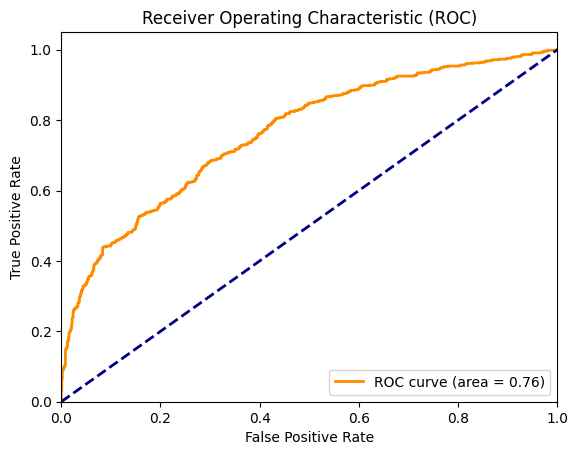

Final Model Accuracy: 0.6994468346650277
Final Model ROC-AUC: 0.7630309845077462


In [ ]:
# 1. Предобработка данных
data_fin = pd.read_csv('/content/drive/MyDrive/MIPT/data_train_data_propadd.csv')
data_fin_test = pd.read_csv('/content/drive/MyDrive/MIPT/data_test_propadd.csv')

# Целевая переменная и признаки
y_train = data_fin['label']
X_train = data_fin.drop(['label', 'class_0_prob'], axis=1)

y_test = data_fin_test['label']
X_test = data_fin_test.drop(['label', 'class_0_prob'], axis=1)

# Нормализация и центрирование дополнительных признаков
# дополнительные признаки
# class_1_prob - первый прогон классификатора файн-тюненый Bert
# combined_prob_product - вероятности слов по мнению Bert через метод маскирования
# combined_prob_difference - скалярная разница между combined_prob_product и вероятностью токена от Bert
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['class_1_prob', 'combined_prob_product', 'combined_prob_difference']])
X_test_scaled = scaler.transform(X_test[['class_1_prob', 'combined_prob_product', 'combined_prob_difference']])

# 2. Обучение и применение BERT классификатора
bert_model = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/MIPT/fine_tuned_classifier')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts, tokenizer, max_length=128):
    texts = texts.astype(str).tolist()
    return pad_sequences(tokenizer(texts, truncation=True, padding=True, max_length=max_length)['input_ids'], maxlen=max_length, padding='post')

X_train_tokens = tokenize_texts(X_train['model_annotation'].values, tokenizer)
X_test_tokens = tokenize_texts(X_test['model_annotation'].values, tokenizer)

bert_probs_train = bert_model.predict(X_train_tokens).logits[:, 1]
bert_probs_test = bert_model.predict(X_test_tokens).logits[:, 1]

# 3. Обучение и применение сверточной нейросети LeNet
def create_lenet_model(input_shape):

    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='elu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lenet_model = create_lenet_model((X_train_tokens.shape[1], 1))
lenet_model.fit(X_train_tokens.reshape(-1, X_train_tokens.shape[1], 1), y_train, epochs=100, batch_size=256, validation_split=0.2)

lenet_probs_train = lenet_model.predict(X_train_tokens.reshape(-1, X_train_tokens.shape[1], 1))
lenet_probs_test = lenet_model.predict(X_test_tokens.reshape(-1, X_test_tokens.shape[1], 1))

# 4. Обучение и применение SVM, случайного леса и градиентного бустинга
def train_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict_proba(X_test)[:, 1]

# Добавляем предсказания LeNet и BERT к признакам
X_train_combined = np.hstack((X_train_scaled, lenet_probs_train, bert_probs_train.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_scaled, lenet_probs_test, bert_probs_test.reshape(-1, 1)))

# Обучаем SVM
svm = SVC(probability=True)
svm.fit(X_train_combined, y_train)
svm_probs_train = svm.predict_proba(X_train_combined)[:, 1]
svm_probs_test = svm.predict_proba(X_test_combined)[:, 1]

X_train_combined = np.hstack((X_train_combined, svm_probs_train.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_combined, svm_probs_test.reshape(-1, 1)))

# Обучаем Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_combined, y_train)
rf_probs_train = rf.predict_proba(X_train_combined)[:, 1]
rf_probs_test = rf.predict_proba(X_test_combined)[:, 1]

X_train_combined = np.hstack((X_train_combined, rf_probs_train.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_combined, rf_probs_test.reshape(-1, 1)))

# Обучаем Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train_combined, y_train)
gb_probs_train = gb.predict_proba(X_train_combined)[:, 1]
gb_probs_test = gb.predict_proba(X_test_combined)[:, 1]

X_train_combined = np.hstack((X_train_combined, gb_probs_train.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_combined, gb_probs_test.reshape(-1, 1)))

# 5. Построение полносвязного классификатора на всех признаках
final_X_train = X_train_combined
final_X_test = X_test_combined

final_model = Sequential()
final_model.add(Dense(64, activation='elu', input_shape=(final_X_train.shape[1],), kernel_regularizer=l2(0.01)))
final_model.add(Dropout(0.5))
final_model.add(Dense(32, activation='elu', kernel_regularizer=l2(0.01)))
final_model.add(Dropout(0.5))
final_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

final_model.fit(final_X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)

final_preds = final_model.predict(final_X_test)
final_accuracy = accuracy_score(y_test, (final_preds > 0.5).astype(int))
final_roc_auc = roc_auc_score(y_test, final_preds)

# Построение графика ROC-AUC
fpr, tpr, _ = roc_curve(y_test, final_preds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {final_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f'Final Model Accuracy: {final_accuracy}')
print(f'Final Model ROC-AUC: {final_roc_auc}')
